In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from bacs.agents.bacs import BACS, Configuration
from bacs.agents.bacs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import my_mazes

## Agent - BACS

### Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Woods101-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
DO_ACTION_PLANNING_EXPLORE = False
DO_GA_EXPLORE = False
DO_SUBSUMPTION_EXPLORE = True
BETA_EXPLORE = 0.05
EPSILON = 0.8

NUMBER_OF_EXPLOIT_TRIALS = 500
DO_ACTION_PLANNING_EXPLOIT = False
DO_SUBSUMPTION_EXPLOIT = True
BETA_EXPLOIT = 0.00

LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

### Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■
■ □ □ □ □ □ ■
■ A ■ □ ■ □ ■
■ □ ■ $ ■ □ ■
■ ■ ■ ■ ■ ■ ■


### Training of BACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=DO_GA_EXPLORE,
    do_subsumption=DO_SUBSUMPTION_EXPLORE,
    do_action_planning=DO_ACTION_PLANNING_EXPLORE,
    action_planning_frequency=50,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 41.2 s, sys: 269 ms, total: 41.4 s
Wall time: 42.9 s


In [5]:
population_explore_to_display = [cl for cl in population_explore if cl.does_anticipate_change()]
for cl in population_explore_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.talp, cl.exp, cl.mark))
    print("\n")

00119110 7 None None 11001001         (empty)               q: 0.982 r: 528.0  ir: 0.0    f: 518.5  exp: 109 tga: 4     talp: 31374 tav: 2.84e+02 num: 1


11001001 3 None None 00119110         (empty)               q: 0.333 r: 924.4  ir: 0.0    f: 307.8  exp: 224 tga: 11    talp: 31780 tav: 2.49e+02 num: 1


001#9#10 0 None None 110#0#01         (empty)               q: 1.0   r: 901.5  ir: 0.0    f: 901.5  exp: 193 tga: 12    talp: 31277 tav: 1.54e+02 num: 1


##0010## 2 None None ##1101##         (11####01)            q: 0.521 r: 901.9  ir: 0.0    f: 469.6  exp: 401 tga: 16    talp: 31707 tav: 1.84e+02 num: 1


1#001001 3 None None 0#110110         (#1######)            q: 0.483 r: 924.4  ir: 0.0    f: 446.9  exp: 224 tga: 23    talp: 31780 tav: 2.49e+02 num: 1


0#110110 7 None None 1#001001         (empty)               q: 0.999 r: 525.0  ir: 0.0    f: 524.5  exp: 110 tga: 29    talp: 31392 tav: 3.46e+02 num: 1


####0##0 4 None None ####1##1         (empty)               q: 0.99  r

### Exploitation of BACS

In [6]:
%%time

cfg_exploit = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=DO_SUBSUMPTION_EXPLOIT,
    do_action_planning=DO_ACTION_PLANNING_EXPLOIT,
    action_planning_frequency=50,
    beta=BETA_EXPLOIT,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=1
)

agent_exploit = BACS(cfg_exploit, population_explore)
agent_exploit.clean_population(does_anticipate_change=True)
population_exploit, metrics_exploit = agent_exploit.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS)

CPU times: user 5.08 s, sys: 4.69 ms, total: 5.08 s
Wall time: 5.09 s


### Performance

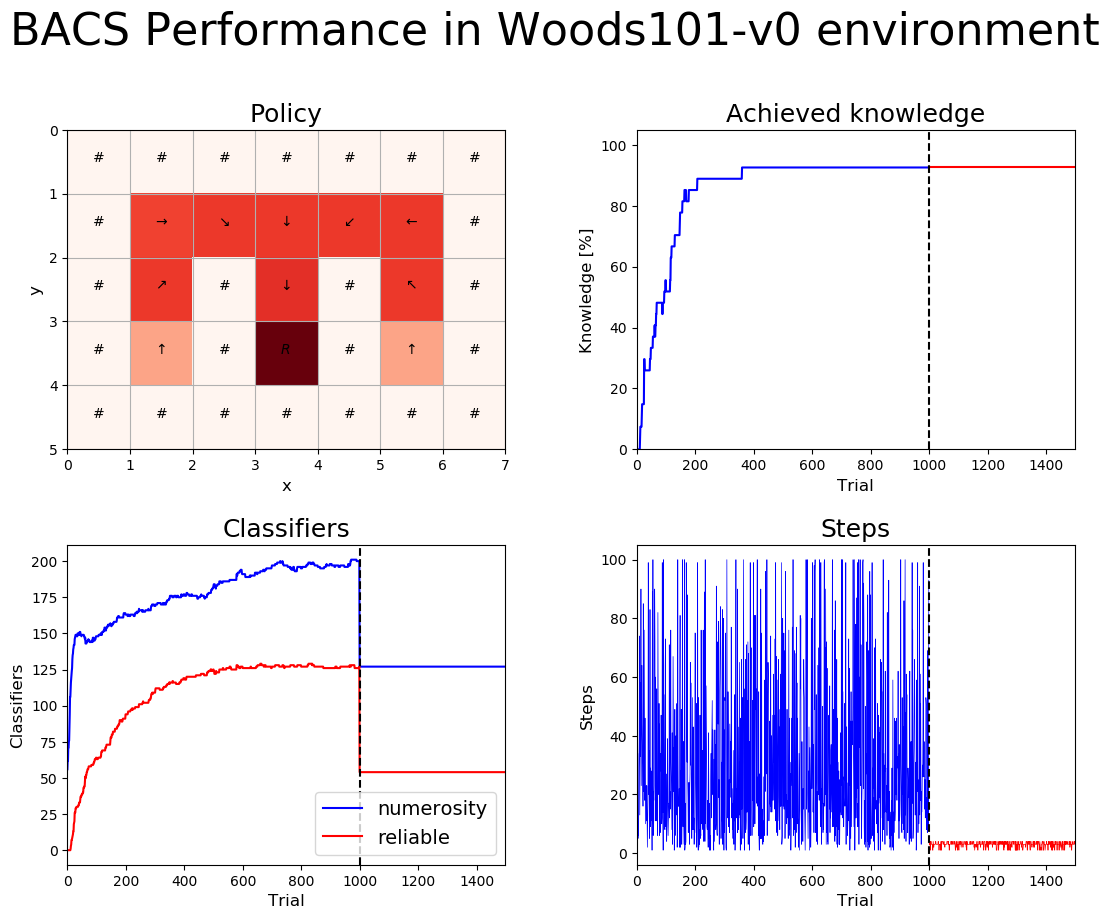

In [7]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)
plot_performance(agent_exploit, maze, metrics_df, cfg_exploit, MAZE)

In [8]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS
avg_step_exploit = 0
for trial in metrics_exploit:
    avg_step_exploit += trial['steps_in_trial']
avg_step_exploit /= NUMBER_OF_EXPLOIT_TRIALS
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")
print("Average number of steps to solve the maze is ",avg_step_exploit,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS, " trials in EXPLOITATION")

Average number of steps to solve the maze is  31.812  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  3.02  for a total of  500  trials in EXPLOITATION


In [9]:
population_exploit.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit]
for cl in population_exploit_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.num, cl.exp, cl.mark))
    print("\n")

#0##9##0 4 None None #1##1##1         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 953 tga: 115   talp: 31811 tav: 33.4   num: 1


0#110110 7 [5] [('1', '1', '0', '0', '1', '0', '0', '1')] #0##9###         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 377 tga: 204   talp: 31776 tav: 92.5   num: 1


110#0#01 4 None None 001#9#10         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 566 tga: 115   talp: 31802 tav: 42.5   num: 1


##11010# 6 [5] [('1', '1', '0', '0', '1', '0', '0', '1')] 00##9#10         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 342 tga: 1038  talp: 31785 tav: 96.9   num: 1


0011011# 1 [3] [('1', '1', '0', '0', '1', '0', '0', '1')] ####9##0         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 615 tga: 107   talp: 31651 tav: 57.7   num: 1


1#1101## 6 [5] [('1', '1', '0', '0', '1', '0', '0', '1')] 00##9#10         (empty)               q: 1.0   r: 950.0  ir: 0.0 